In [11]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import ForwardDiff
import Convex as cvx 
import ECOS
using LinearAlgebra
using Plots

  Activating environment at `~/Documents/CMU-Projects/MRSD/Sem2/OCRL/cbf/Project.toml`


In [12]:
function double_integrator_AB(dt)::Tuple{Matrix,Matrix}
    Ac = [0 0 1 0;
          0 0 0 1;
          0 0 0 0;
          0 0 0 0.]
    Bc = [0 0;
          0 0;
          1 0;
          0 1]
    nx, nu = size(Bc)
        
    # TODO: discretize this linear system using the Matrix Exponential
    
    # matrix exponential 
    H = exp([Ac Bc; zeros(nu, nx + nu)]*dt)
    A = H[1:nx,1:nx]
    B = H[1:nx,(nx + 1):(nx + nu)]
    
    return A, B 
end

double_integrator_AB (generic function with 1 method)

In [48]:
function mobile_base_cost(N, X, Xtraj, U)::Real
    
    J = 0 
    Q = diagm(ones(4))
    R = 0.1*diagm(ones(2))
    Qf = 10*diagm(ones(4))
    
    for i = 1:(N-1)
        #stage cost
        J += 0.5 * transpose(X[i]-Xtraj[i]) * Q * (X[i]-Xtraj[i]) + 0.5 * transpose(U[i]) * R * U[i]
    end
    
    # terminal cost 
    J += 0.5 * transpose(X[N]-Xtraj[N]) * Qf * (X[N]-Xtraj[N]) 
    
    return J 
end

mobile_base_cost (generic function with 2 methods)

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342


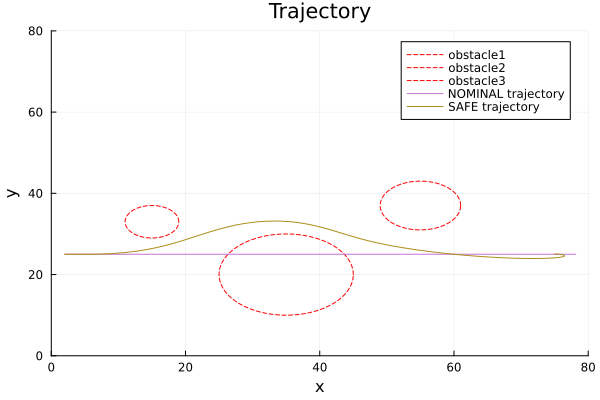

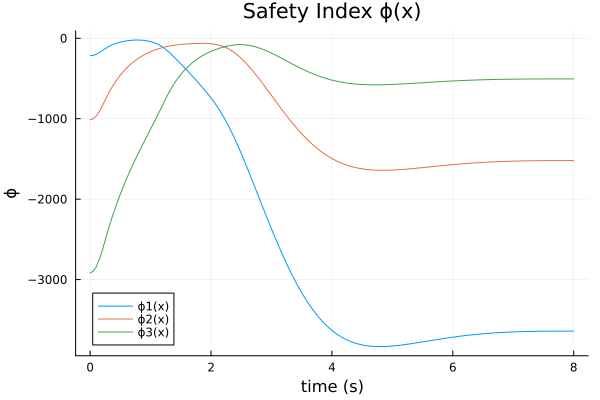

cost = mobile_base_cost(N, X, X_nominal, u) = 37407.8747960028


37407.8747960028

In [52]:
function ϕ1(x)
    p = x[1:2]  
    -(norm(p - [15,33])^2 - 4^2) 
end
function ∇ϕ1(x)
    ForwardDiff.gradient(ϕ1, x)
end

function ϕ2(x)
    p = x[1:2]  
    -(norm(p - [35,20])^2 - 10^2) 
end
function ∇ϕ2(x)
    ForwardDiff.gradient(ϕ2, x)
end

function ϕ3(x)
    p = x[1:2] 
    -(norm(p - [55,37])^2 - 6^2) 
end
function ∇ϕ3(x)
    ForwardDiff.gradient(ϕ3, x)
end


function cbf(x::Vector,  # current state 
             u0::Vector, # nominal control input 
             A::Matrix,  # discrete time A 
             B::Matrix,  # discrete time B 
             dt::Real)   # time step size 
    
    # tune this (lower the number = more aggressive)
    λ1 = -5
    λ2 = -2
    λ3 = -2
    
    # our variable we are solving for 
    u = cvx.Variable(2)
    
    # let's approximate xdot with a difference between (x_{k+1} - x_k)/dt
    # this is because if we just did the continuous time dynamics, ϕdot would 
    # be zero. This is because if x = [p;v], dϕ/dx = [dϕ/dp; 0] since it only depends on 
    # the position, not velocity. our continous time dynamics are xdot = [v;u], meaning when
    # we take ∇ϕ'ẋ, we get [dϕ/dp; 0]'[v;u], which is not a function of u. This is because u
    # cannot directly affect ṗ. If instead we average xdot over a time step, u can now affect
    # ṗ, and everything works out. 
    xdot = ((A*x + B*u) - x)/dt
    
    xdot, eltype(xdot)
    
    ϕ1dot = transpose(∇ϕ1(x))*xdot 
    ϕ2dot = transpose(∇ϕ2(x))*xdot 
    ϕ3dot = transpose(∇ϕ3(x))*xdot 

    # find the closest control to the given u0
    prob = cvx.minimize(cvx.sumsquares(u - u0))
    
    prob.constraints += [ϕ1dot <= λ1*ϕ1(x)]
    prob.constraints += [ϕ2dot <= λ2*ϕ2(x)]
    prob.constraints += [ϕ3dot <= λ3*ϕ3(x)]
    
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    return vec(u.value)
end

function circle()
    
    center1 = [15., 33.]
    rad1 = 4
    θs = range(0,2*pi,length = 100)
    points1 = [(rad1*[cos(θ),sin(θ)]+center1) for θ in θs]

    center2 = [35., 20.]
    rad2 = 10
    θs = range(0,2*pi,length = 100)
    points2 = [(rad2*[cos(θ),sin(θ)]+center2) for θ in θs]

    center3 = [55., 37.]
    rad3 = 6
    θs = range(0,2*pi,length = 100)
    points3 = [(rad3*[cos(θ),sin(θ)]+center3) for θ in θs]

    x1 = [p[1] for p in points1]
    y1 = [p[2] for p in points1]

    x2 = [p[1] for p in points2]
    y2 = [p[2] for p in points2]

    x3 = [p[1] for p in points3]
    y3 = [p[2] for p in points3]


    return x1, y1, x2, y2, x3, y3
end
    
let 
    
    # double integrator dynamics 
    dt = 0.05 
    A,B = double_integrator_AB(dt)
    tf = 8.0 
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    X = [zeros(4) for i = 1:N]
    u = [zeros(2) for i = 1:N-1]
    X[1] = [2,25,0,0]
    
    X_nominal = [zeros(4) for i = 1:N]
    X_nominal[1] = [2,25,0,0]
    
    Xdes = [75,25,0,0]
    
    ref_traj = []
    
    # simple PD controller
    kp = 2.0; kd = 2.0 
    K = [kp*I(2)  kd*I(2)]
    
    # sim 
    for i = 1:(N-1)
        u0_nominal = -K*(X_nominal[i]-Xdes)  # nominal control 
        X_nominal[i+1] = A*X_nominal[i] + B*u0_nominal
        
        u0 = -K*(X[i]-Xdes)          
        u[i] = cbf(X[i],u0,A,B,dt) # modified safe control 
        X[i+1] = A*X[i] + B*u[i]
        
    end
    
#     @show size(X), size(X_nominal), size(u)
    Xm = hcat(X...)
    Xnom = hcat(X_nominal...)
    
    
    x1, y1, x2, y2, x3, y3 = circle()
    plot(x1,y1,lc = :red, ls = :dash,label = "obstacle1")
    xlims!(0,80)
    ylims!(0,80)
    plot!(x2,y2,lc = :red, ls = :dash,label = "obstacle2")
    plot!(x3,y3,lc = :red, ls = :dash,label = "obstacle3")
    plot!(Xnom[1,:],Xnom[2,:], label  = "NOMINAL trajectory", xlabel = "x", ylabel = "y", title = "Trajectory")
    display(plot!(Xm[1,:],Xm[2,:], label  = "SAFE trajectory", xlabel = "x", ylabel = "y", title = "Trajectory"))
    
    ϕs1 = ϕ1.(X)
    plot(t_vec,ϕs1,label = "ϕ1(x)",xlabel = "time (s)", ylabel = "ϕ", title = "Safety Index ϕ(x)")
    
    ϕs2 = ϕ2.(X)
    plot!(t_vec,ϕs2,label = "ϕ2(x)",xlabel = "time (s)", ylabel = "ϕ", title = "Safety Index ϕ(x)")
    
    ϕs3 = ϕ3.(X)
    display(plot!(t_vec,ϕs3,label = "ϕ3(x)",xlabel = "time (s)", ylabel = "ϕ", title = "Safety Index ϕ(x)"))
    
    @show cost = mobile_base_cost(N, X, X_nominal, u)
    
    
end